# Simple Time series LSTM 

LSTM (Long term Short Term memory)
* **RNN (Recurrent Neural Network)** has problem about long term memory, **LSTM** has improvement about that
* Our **Time series LSTM** is focusing on predicting passanger's count on next month, when **LSTM** gets passanger's count during before 12 months

<hr>

How to use this notebook :

There is only minimum explanation

This notebook could be helpful for who want to see how code works right away

Please upvote if it was helpful !

<hr>

## Content
1. [Libraries import](#one)
2. [Prepare Data](#two)
3. [Modeling](#three)
4. [Training & Evaluation](#four)

<hr>

<a id="one"></a>
# 1. Libraries import

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn import model_selection
from keras import models, layers


In [2]:
# this is for visualization
# we can skip this part (not important)

class skeras() :
    def save_history_history(fname, history_history, fold=''):
        np.save(os.path.join(fold, fname), history_history)


    def load_history_history(fname, fold=''):
        history_history = np.load(os.path.join(fold, fname)).item(0)
        return history_history


    def plot_acc(history, title=None):
        # summarize history for accuracy
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        if title is not None:
            plt.title(title)
        plt.ylabel('Accracy')
        plt.xlabel('Epoch')
        plt.legend(['Training data', 'Validation data'], loc=0)
        # plt.show()


    def plot_loss(history, title=None):
        # summarize history for loss
        if not isinstance(history, dict):
            history = history.history

        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        if title is not None:
            plt.title(title)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Training data', 'Validation data'], loc=0)
        # plt.show()


    def plot_history(history):
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plot_acc(history)
        plt.subplot(1, 2, 2)
        plot_loss(history)


    def plot_loss_acc(history):
        plot_loss(history, '(a) Loss trajectory')
        plt.show()            
        plot_acc(history, '(b) Accracy trajectory')
        plt.show()


    def plot_acc_loss(history):
        plot_acc(history, '(a) Accracy trajectory')
        plt.show()
        plot_loss(history, '(b) Loss trajectory')
        plt.show()

<a id="two"></a>
# 2. Prepare Data

* We need to put **'international-airline-passengers.csv'** in our input data
* 144 rows
* Data has 2 columns (Month and passangers)
* **Month** ex) 1949-01, **passangers** ex) 112

In [3]:
fname='../input/international-airline-passengers/international-airline-passengers.csv'
pd.read_csv(fname, engine='python', skipfooter=3)

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
# bring our data as pandas dataframe
def load_data(fname='../input/international-airline-passengers/international-airline-passengers.csv'):
        
    # usecols=[1] means only passangers count
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)        
        
    # we change data type from dataframe to 1-dimension numpy 
    data = dataset.values.reshape(-1)
        
    # check
    plt.plot(data)
    plt.xlabel('Time'); plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()

    # data normalize (because LSTM learn 0~1 values)
    data_dn = (data - np.mean(data)) / np.std(data) / 5
    plt.plot(data_dn)
    plt.xlabel('Time'); plt.ylabel('Normalized #Passengers')
    plt.title('Normalized data by $E[]$ and $5\sigma$')
    plt.show()

    return data_dn    


**Here is important**

we will make time series dataset

* x = last 12 months passanger count     ex) 1(Jan) ~ 12(Dec)
* y = right after x month                ex ) 13(1)(Jan)


In [5]:
# this function makes dataset for Using Rate of change about D months predict next month passanger count
def get_Xy(data, D=12):
    # make X and y
    X_l = []
    y_l = []
    N = len(data) # 144
    assert N > D, "N should be larger than D, where N is len(data)"
    for ii in range(N-D-1): # 0 ~ 131
        X_l.append(data[ii:ii+D])
        y_l.append(data[ii+D])
    X = np.array(X_l)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_l)
    print(X.shape, y.shape)
    return X, y

In [6]:
data = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3).values.reshape(-1)

# we can check x = (131,12,1), y = (131)
print(get_Xy(data))

(131, 12, 1) (131,)
(array([[[112],
        [118],
        [132],
        ...,
        [119],
        [104],
        [118]],

       [[118],
        [132],
        [129],
        ...,
        [104],
        [118],
        [115]],

       [[132],
        [129],
        [121],
        ...,
        [118],
        [115],
        [126]],

       ...,

       [[463],
        [407],
        [362],
        ...,
        [535],
        [622],
        [606]],

       [[407],
        [362],
        [405],
        ...,
        [622],
        [606],
        [508]],

       [[362],
        [405],
        [417],
        ...,
        [606],
        [508],
        [461]]]), array([115, 126, 141, 135, 125, 149, 170, 170, 158, 133, 114, 140, 145,
       150, 178, 163, 172, 178, 199, 199, 184, 162, 146, 166, 171, 180,
       193, 181, 183, 218, 230, 242, 209, 191, 172, 194, 196, 196, 236,
       235, 229, 243, 264, 272, 237, 211, 180, 201, 204, 188, 235, 227,
       234, 264, 302, 293, 259, 229, 203, 229, 

In [7]:
class Dataset:
    
    # initialize (data name & D (time-series length))
    def __init__(self, fname='../input/international-airline-passengers/international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        X, y = get_Xy(data_dn, D=D)
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)  
        
        # after initializing , we can see output when we use this class
        self.X, self.y = X, y
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test   

    


<a id="three"></a>
# 3. Modeliing

In [8]:
def rnn_model(shape):
    
    # input (12,1)
    m_x = layers.Input(shape=shape) #X.shape[1:]
    
    # hidden (10)
    m_h = layers.LSTM(10)(m_x)
    
    # output (1)
    m_y = layers.Dense(1)(m_h)
    m = models.Model(m_x, m_y)
    
    # show me summary about model
    m.compile('adam', 'mean_squared_error')
    m.summary()
    
    return m

<a id="four"></a>
# 4. Training & Evaluation

In [9]:
class Machine():
    def __init__(self):
        # bring data
        self.data = Dataset()
        
        # input data size (12,1)
        shape = self.data.X.shape[1:]
        
        # make LSTM model
        self.model = rnn_model(shape)
        
    def run(self, epochs=400):
        d = self.data
        
        # we made internal variables in Class Dataset()
        X_train, X_test, y_train, y_test = d.X_train, d.X_test, d.y_train, d.y_test
        X, y = d.X, d.y
        
        # training
        m = self.model 
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)

        # after training show us training curve
        skeras.plot_loss(h)
        plt.title('History of training')
        plt.show()

        # evaluate() show us training efficiency after training
        yp = m.predict(X_test)
        print('Loss:', m.evaluate(X_test, y_test))
        
        # make two graph for comparing
        plt.plot(yp, label='Origial')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()
        
        #   upside         >>>>>>>>>>>>>      we cant find out Time series relationship
        #-----------------------------------------------------------------------------------------------
        #   downside       >>>>>>>>>>>>>      we use seaborn and pandas's dataframe to find Time series relationship
        
        yp = m.predict(X_test).reshape(-1)
        print('Loss:', m.evaluate(X_test, y_test))  
        print(yp.shape, y_test.shape)

        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        # Sample column's first = purpose order, second = predict order
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['Prediction'] * len(yp)

        plt.figure(figsize=(7, 5))
        sns.barplot(x="Sample", y="Normalized #Passengers", hue="Type", data=df)
        plt.ylabel('Normalized #Passengers')
        plt.show()
        
        yp = m.predict(X)
        plt.plot(yp, label='Origial')
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()


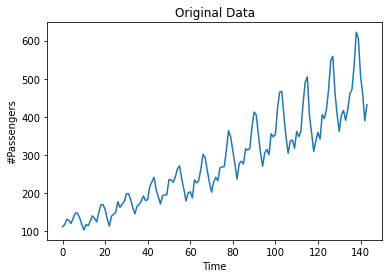

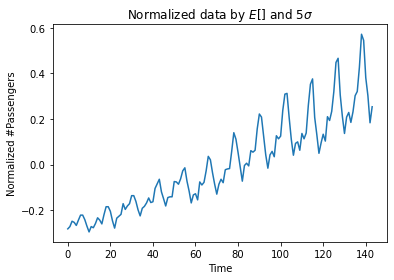

(131, 12, 1) (131,)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


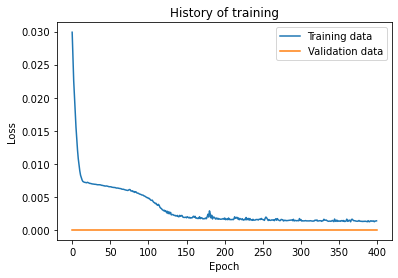

1/1 [==============================] - 0s 1ms/step - loss: 0.0014
Loss: 0.0014429162256419659


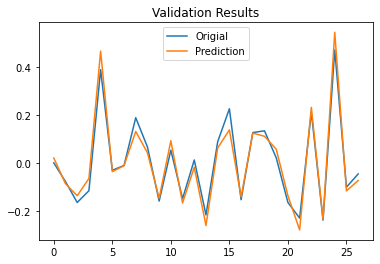

1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Loss: 0.0014429162256419659
(27,) (27,)


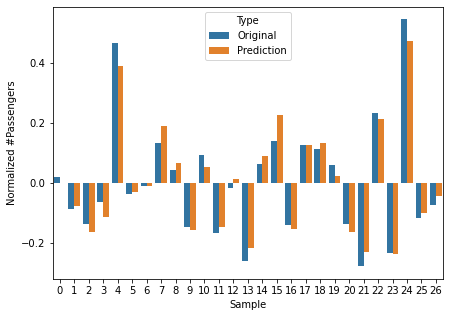

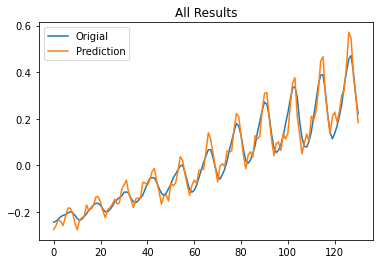

In [10]:
def main():        
    machine = Machine() 
    machine.run(epochs=400)

if __name__ == '__main__' :
    main()

## Reference
* Coding chef 3 minute deep learning  - [ex5_1_lstm_imdb](https://github.com/jskDr/keraspp/blob/master/ex5_2_lstm_airplane.py)
* [Simple LSTM](https://www.kaggle.com/gigunlee/beginner-simple-lstm)